# Imports and set up

In [31]:
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

# Clustering
from sklearn.cluster import KMeans
import spacy

# Tuning and evaluation
from edawesome.sklearn_help import pretty_classification_report
import optuna
from tqdm import tqdm
from sklearn.metrics import make_scorer, f1_score

# Models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

import pickle
import os
from functools import partial

SEED = 42

# Get the training data

In [2]:
status_df = pd.read_csv(os.path.join('data', 'sampled_data', 'part-00000-764dd3a4-49cd-441c-8e5b-afdcfdb876f9-c000.csv'))
status_df

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,STD(installments_payments.days_instalment),STD(installments_payments.num_instalment_number),STD(installments_payments.num_instalment_version),SUM(installments_payments.amt_instalment),SUM(installments_payments.amt_payment),SUM(installments_payments.days_entry_payment),SUM(installments_payments.days_instalment),SUM(installments_payments.num_instalment_number),SUM(installments_payments.num_instalment_version),sk_id_curr
0,0,Cash loans,M,N,Y,0,180000.0,1256400.0,40657.5,900000.0,...,1132.148869,1.311372,0.651339,396686.745,351382.905,-17808.0,-17842.0,31.0,16.0,100077
1,1,Cash loans,F,N,Y,1,202500.0,436032.0,28516.5,360000.0,...,498.826664,2.833591,0.315302,153254.655,153254.655,-37989.0,-37516.0,92.0,21.0,100214
2,0,Cash loans,F,N,Y,0,135000.0,81000.0,9135.0,81000.0,...,99.208405,3.306947,0.277350,236209.905,202422.735,-2226.0,-2169.0,85.0,14.0,100258
3,0,Cash loans,F,N,Y,1,63000.0,284400.0,18513.0,225000.0,...,56.124861,1.870829,0.000000,70005.285,70005.285,-2189.0,-2106.0,21.0,6.0,100915
4,0,Cash loans,M,Y,Y,1,202500.0,518562.0,25078.5,463500.0,...,143.755580,6.512040,0.500000,503202.195,503202.195,-5048.0,-4850.0,241.0,5.0,101013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30900,1,Cash loans,M,N,Y,0,135000.0,545040.0,25407.0,450000.0,...,115.790065,39.993347,1.172292,98626.680,79161.570,-7051.0,-6777.0,520.0,29.0,452218
30901,0,Cash loans,M,N,N,0,54000.0,454500.0,14661.0,454500.0,...,1637.456971,1.290994,0.000000,39165.660,39165.660,-5922.0,-5856.0,10.0,4.0,453130
30902,0,Cash loans,M,Y,Y,0,216000.0,531000.0,27243.0,531000.0,...,230.555425,17.064648,0.289097,483990.615,483990.615,-25251.0,-25043.0,1656.0,3.0,453147
30903,1,Revolving loans,F,N,N,0,225000.0,270000.0,13500.0,270000.0,...,479.368384,3.389760,0.358569,109731.195,109731.195,-21559.0,-21113.0,103.0,24.0,453420


In [3]:
previous_df = pd.read_csv(os.path.join('data', 'full_bureau_data', 'part-00000-c2006b9e-3b5a-4da2-b162-6fd3ffda3635-c000.csv'))
previous_df

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [4]:
previous_df.drop(columns=['sk_id_curr', 'sk_id_bureau'], inplace=True)

In [5]:
aggregated_cols = status_df.columns[status_df.columns.str.contains('\(')]
status_df.drop(aggregated_cols, axis=1, inplace=True)

In [6]:
status_df.drop(columns=['sk_id_curr'], inplace=True)

In [7]:
not_treated = pickle.load(open(os.path.join('data', 'not_treated.pickle'), 'rb'))
not_treated

('occupation_type', 'organization_type')

### Numeric and categorical features

In [8]:
def set_categories(dataframe: pd.DataFrame, cat_threshold: int = 10) -> None:

    cat_features = [cat_name for cat_name in dataframe.columns if dataframe[cat_name].nunique() <= cat_threshold]
    dataframe[cat_features] = dataframe[cat_features].astype('category')

In [9]:
set_categories(status_df, cat_threshold=10)
set_categories(previous_df, cat_threshold=10)

cats = status_df.select_dtypes('category').columns
status_df[cats] = status_df[cats].astype('str')

cats = previous_df.select_dtypes('category').columns
previous_df[cats] = previous_df[cats].astype('str')

### Custom metric

For loan repayment status, we will use the custom metric, which shows how much money the bank looses:

In [10]:
def custom_metric(true_class, predicted_class, amt_credit, interest_rate=0.1, not_paid_rate=0.05, decimal_places_num=6):

    if decimal_places_num > 6:
        raise ValueError('decimal_places_num must be less or equal to 6')

    # Is false positive
    # We predict a loan will be repaid, but it actually isn't repaid
    fp = (predicted_class == 0) & (true_class == 1)

    # Is false negative
    # We predict a loan won't be repaid, but it actually is repaid
    fn = (predicted_class == 1) & (true_class == 0)

    # Price of false positive error
    fp_cost = fp * amt_credit * not_paid_rate

    # Price of false negative error
    fn_cost = fn * amt_credit * interest_rate

    # Total cost
    total_cost = (fp_cost + fn_cost).sum()
    
    # Maximum total cost with dummy prediction, when we predict all loans will be repaid
    max_cost = ((true_class == 1) * amt_credit).sum() * not_paid_rate

    # Calculate the score and round it to maximum 6 decimal places
    # Rounding is needed to avoid not exact floating point calculations
    score = 1 / (1 + total_cost / max_cost)
    score = round(score, decimal_places_num)

    return score

# Loan repayment status

### Feature engineering

##### Ratio features

After exploring column descripttions, I've came up with 12 useful pairs of columns, which can be used to create new ratio features:

1) AMT_INCOME_TOTAL and AMT_CREDIT: This ratio could be useful for understanding the relative size of a loan relative to a borrower's income

2) AMT_INCOME_TOTAL and AMT_ANNUITY: This ratio could be useful for understanding the relative size of a borrower's annual payments relative to their income

3) AMT_CREDIT and AMT_ANNUITY: This ratio could be useful for understanding the relative size of a borrower's credit relative to their annual payments

4) DAYS_BIRTH and DAYS_EMPLOYED: This ratio could be useful for understanding the relative age of a borrower at the time of their loan application relative to the length of their employment\

5) AMT_CREDIT and AMT_GOODS_PRICE: This ratio could be useful for understanding the relative size of a loan relative to the price of the goods being purchased with the loan

6) AMT_INCOME_TOTAL and AMT_GOODS_PRICE: This ratio could be useful for understanding the relative size of the goods being purchased with the loan relative to a borrower's income

7) AMT_ANNUITY and AMT_GOODS_PRICE: This ratio could be useful for understanding the relative size of the goods being purchased with the loan relative to a borrower's annual payments

8) CNT_FAM_MEMBERS and CNT_CHILDREN: This ratio could be useful for understanding the relative number of family members and children in a borrower's household

9) AMT_CREDIT and AMT_GOODS_PRICE: This ratio could be useful for understanding the relative size of a loan relative to the price of the goods being purchased with the loan

10) AMT_REQ_CREDIT_BUREAU_YEAR and AMT_REQ_CREDIT_BUREAU_MON: This ratio could be useful for understanding the relative number of credit inquiries made by a borrower over the past year relative to the past month

11) AMT_CREDIT and AMT_REQ_CREDIT_BUREAU_YEAR: This ratio could be useful for understanding the relative size of a borrower's credit relative to the number of credit inquiries made by the borrower over the past year

12) AMT_INCOME_TOTAL and AMT_REQ_CREDIT_BUREAU_YEAR: This ratio could be useful for understanding the relative size of a borrower's income relative to the number of credit inquiries made by the borrower over the past year

In [11]:
class RatioFeaturesGenerator(BaseEstimator, TransformerMixin):
    def __init__(self, ratio_columns):
        self.ratio_columns = ratio_columns
        
    def fit(self, data, y=None):
        return self
    
    def transform(self, data, y=None):
        X = data.copy()
        for col1, col2 in self.ratio_columns:
            
            ratio_col = f'{col1}_{col2}_ratio'
            X[ratio_col] = X[col1] / X[col2]

            # Replace infinities with nan
            X[ratio_col] = X[ratio_col].replace([np.inf, -np.inf], np.nan)

            # Replace nans with the mean of the column
            X[ratio_col] = X[ratio_col].fillna(X[ratio_col].mean())

        return X

    def get_feature_names_out(self, input_features=None):
    
        if input_features is None:
            input_features = self.X.columns.tolist()

        return input_features

In [12]:
ratio_columns = [
    ('amt_income_total', 'amt_credit'),
    ('amt_income_total', 'amt_annuity'),
    ('amt_credit', 'amt_annuity'),
    ('days_birth', 'days_employed'),
    ('amt_credit', 'amt_goods_price'),
    ('amt_income_total', 'amt_goods_price'),
    ('amt_annuity', 'amt_goods_price'),
    ('cnt_fam_members', 'cnt_children'),
    ('amt_credit', 'amt_goods_price'),
    ('amt_req_credit_bureau_year', 'amt_req_credit_bureau_mon'),
    ('amt_credit', 'amt_req_credit_bureau_year'),
    ('amt_income_total', 'amt_req_credit_bureau_year'),
]

In [13]:
for pair in ratio_columns:
    for col in pair:
        status_df[col] = status_df[col].astype('float')
# we need this conversion, because some of the numeric columns were treated as categorical

### Split into train and test

In [14]:
X = status_df.drop(['ext_source_1', 'ext_source_2', 'ext_source_3', 'target'], axis='columns')
y, amt_credit = status_df.target, status_df.amt_credit

# check missing values in target
y.isna().sum()

# convert target to int
y = y.astype(int)

X_train, X_test, y_train, y_test, amt_credit_train, amt_credit_test = train_test_split(
    X, y, amt_credit, test_size=0.2, random_state=SEED
)

### Not treated features

In [15]:
# Create a function which creates a cluster column to add to the pipeline

def create_cluster_column(column, n_clusters=5, random_state=SEED):

        # convert to pandas series and get unique values
        column = pd.Series(column, name='COLUMN')
        words = column.unique()

        # tokenize and vectorize with SpaCy
        nlp = spacy.load('en_core_web_sm')
        tokens = [nlp(str(elem)) for elem in words]
        vectors = [token.vector for token in tokens]
        
        # cluster with kmeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans.fit(vectors)
        clusters = kmeans.labels_

        # create a dataframe with the clusters
        clusters_df = pd.DataFrame({'COLUMN': column.unique(), 'cluster': clusters})

        # when value is "Not provided", make cluster = -1
        clusters_df.loc[clusters_df['COLUMN'] == 'Not provided', 'cluster'] = -1

        # merge the clusters with the original dataframe
        merged_df = column.to_frame().merge(clusters_df, on='COLUMN', how='left')
    
        return merged_df.cluster

In [16]:
# Create a custom transformer using the function above
class Cluster(BaseEstimator, TransformerMixin):

    def __init__(self, n_clusters=5, random_state=SEED, col_names=None):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.col_names = col_names

    def fit(self, data, y=None):
        return self

    def transform(self, data, y=None):

        data = data.copy()

        for col in self.col_names:
            cluster_name = col + '_cluster'
            data[cluster_name] = create_cluster_column(X[col], self.n_clusters, self.random_state)
            data[cluster_name] = data[cluster_name].astype('str')

        return data

    def get_feature_names_out(self, input_features=None):
        
        if input_features is None:
            input_features = self.data.columns.tolist()

        return input_features

### Encoding, scaling, imputing

In [17]:
# numerical pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('ratios', RatioFeaturesGenerator(ratio_columns))
])

# categorical pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not provided')),
    ('clustering', Cluster(col_names=not_treated)),
    ('categorical_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# create pipeline for predictors
encoding_col_transformer = ColumnTransformer([
    ('numeric_transformer', numeric_transformer, selector(dtype_include ='number')),
    ('categorical_transformer', categorical_transformer, selector(dtype_exclude='number'))
], remainder='passthrough')

In [18]:
encoding_col_transformer.set_output(transform='pandas')

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler()),
                                                 ('ratios',
                                                  RatioFeaturesGenerator(ratio_columns=[('amt_income_total',
                                                                                         'amt_credit'),
                                                                                        ('amt_income_total',
                                                                                         'amt_annuity'),
                                                                                        ('amt_credit',
                                                                                         'amt_annuity'),
                                                                                        ('days_birth',
                                                                                         'days_employed'),
                                                                                        ('amt...
                                ('categorical_transformer',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='Not '
                                                                           'provided',
                                                                strategy='constant')),
                                                 ('clustering',
                                                  Cluster(col_names=('occupation_type',
                                                                     'organization_type'))),
                                                 ('categorical_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f3abc8af3d0>)])

In [19]:
X_train_prepared = encoding_col_transformer.fit_transform(X_train)

/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/dreamtim/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain 

In [20]:
X_test_prepared = encoding_col_transformer.transform(X_test)

/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/home/dreamtim/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/dreamtim/anaconda3/lib/python3.8/site-packages/spacy/util.py:877: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2 and may not be 100% compatible with the current version (3.4.3). If you see errors or degraded performance, download a newer compatible model or retrain 

In [21]:
X_train_prepared

,numeric_transformer__cnt_children,numeric_transformer__amt_income_total,numeric_transformer__amt_credit,numeric_transformer__amt_annuity,numeric_transformer__amt_goods_price,numeric_transformer__region_population_relative,numeric_transformer__days_birth,numeric_transformer__days_employed,numeric_transformer__days_registration,numeric_transformer__days_id_publish,...,categorical_transformer__flag_document_18,categorical_transformer__flag_document_19,categorical_transformer__flag_document_20,categorical_transformer__flag_document_21,categorical_transformer__amt_req_credit_bureau_hour,categorical_transformer__amt_req_credit_bureau_day,categorical_transformer__amt_req_credit_bureau_week,categorical_transformer__amt_req_credit_bureau_qrt,categorical_transformer__occupation_type_cluster,categorical_transformer__organization_type_cluster
27272,-0.573191,-0.573858,-0.227841,-0.385459,-0.229967,-0.668209,0.204995,-0.463541,-1.217685,-0.612236,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0
21122,-0.573191,-0.253562,0.450494,0.332500,0.366090,0.122082,1.295156,-0.467395,-0.051033,-0.080466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0
19842,2.197671,0.020978,-0.261322,-0.164715,-0.120487,-1.253001,0.999134,-0.466084,0.290863,-0.620172,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
24848,2.197671,-0.345075,1.140842,1.231885,0.998641,3.716365,0.476904,-0.491670,-0.880905,-0.013665,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7793,-0.573191,0.341275,-0.149682,-0.009916,0.001158,0.838013,-0.310805,-0.475583,0.137678,1.350152,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,3.583102,-0.345075,0.113364,0.410829,-0.047500,0.749242,0.902221,-0.465993,1.112778,0.322329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
5390,2.197671,0.570058,-0.798533,-0.376171,-0.850352,-1.327577,0.938506,-0.464710,1.291542,-0.105600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
860,0.812240,-0.528102,2.346140,1.242102,2.190755,-0.015686,0.580707,-0.475957,0.648675,-0.222007,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0
15795,-0.573191,-0.573858,0.676453,0.686062,0.901325,-0.897558,1.168847,-0.479896,1.049969,-0.429688,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0


### Some helper functions for tuning

In [22]:
# optuna callback to show progress bar, since their callback is not working properly
# TODO: fix it for new version of optuna
class OptunaProgressBar:
    
    def __init__(self, n_iter):
        self.n_iter = n_iter * 2
        self.pbar = tqdm(total=self.n_iter)
        
    def __call__(self, study, trial):
        self.pbar.update(1)
        self.pbar.set_description(f'Score: {trial.value:.4f} (best - {study.best_value:.4f}, trial {study.best_trial.number})')
        self.pbar.update()

        if trial.number == self.n_iter:
            self.pbar.close()

    def close(self):
        self.pbar.close()

In [23]:
def get_estimator(base_params, study, model):
    params = study.best_params
    params.update(base_params)
    return model(**params)

In [24]:
# Used in OptunaSearchCV and tqdm
N_ITER = 300

### Split train into train and validation, downsample train

In [25]:
# split train data into train and validation
X_train_train, X_train_val, y_train_train, y_train_val, amt_credit_train_train, amt_credit_train_val = train_test_split(
    X_train_prepared, y_train, amt_credit_train, test_size=0.2, random_state=SEED
)

In [26]:
# downample train data
sampler = RandomUnderSampler(random_state=SEED, sampling_strategy=0.5)
X_train_train_downsampled, y_train_train_downsampled = sampler.fit_resample(X_train_train, y_train_train)

In [27]:
train_custom_metric = partial(custom_metric, amt_credit=amt_credit_train_val)
test_custom_metric = partial(custom_metric, amt_credit=amt_credit_test)

In [28]:
train_scorer = make_scorer(train_custom_metric, greater_is_better=True)
test_scorer = make_scorer(test_custom_metric, greater_is_better=True)

### Random forest

In [29]:
# params which are equal for all runs
random_forest_params = {
    'random_state': SEED,
    'n_jobs': -1,
}

def objective(trial):

    # hyperparameters

    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # model
    model = RandomForestClassifier(
        **random_forest_params,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    model.fit(X_train_train_downsampled, y_train_train_downsampled)
    y_pred = model.predict(X_train_val)
    score = train_scorer(model, X_train_val, y_train_val)

    return score

N_ITER = 200

In [30]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction='maximize', study_name='random_forest')

study.optimize(objective, n_trials=N_ITER, n_jobs=-1, callbacks=[OptunaProgressBar(N_ITER)])

Score: 0.5000 (best - 0.5000, trial 8): 100%|██████████| 400/400 [04:18<00:00,  1.55it/s]


In [31]:
random_forest = get_estimator(random_forest_params, study, RandomForestClassifier)

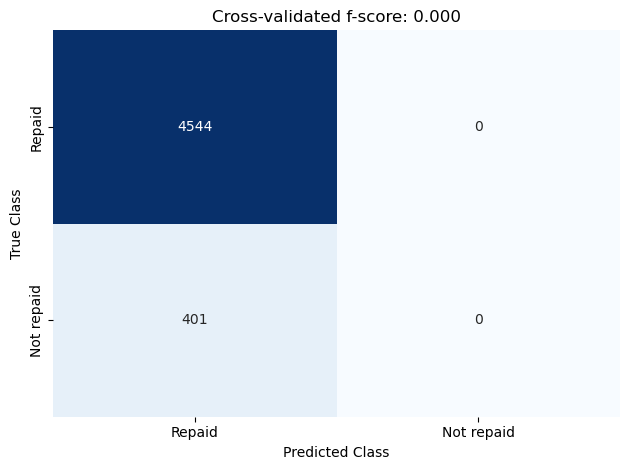

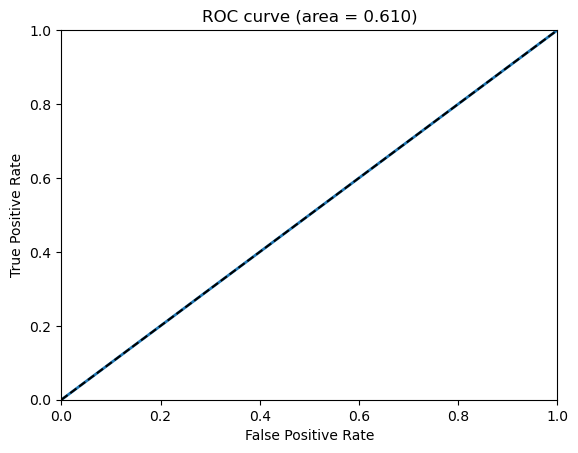

In [34]:
random_forest.fit(X_train_prepared, y_train)

y_pred = random_forest.predict(X_train_val)

pretty_classification_report(random_forest, X_train_val, y_train_val, class_names=[['Repaid', 'Not repaid']])

### Random forest without custom metric

In [29]:
# params which are equal for all runs
random_forest_params = {
    'random_state': SEED,
    'n_jobs': -1,
}

def objective(trial):

    # hyperparameters

    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    # model
    model = RandomForestClassifier(
        **random_forest_params,
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    
    model.fit(X_train_train_downsampled, y_train_train_downsampled)
    y_pred = model.predict(X_train_val)
    score = f1_score(y_train_val, y_pred)

    return score

N_ITER = 200

In [30]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction='maximize', study_name='random_forest')

study.optimize(objective, n_trials=N_ITER, n_jobs=-1, callbacks=[OptunaProgressBar(N_ITER)])

Score: 0.1396 (best - 0.1679, trial 157): 100%|██████████| 400/400 [02:52<00:00,  2.31it/s]


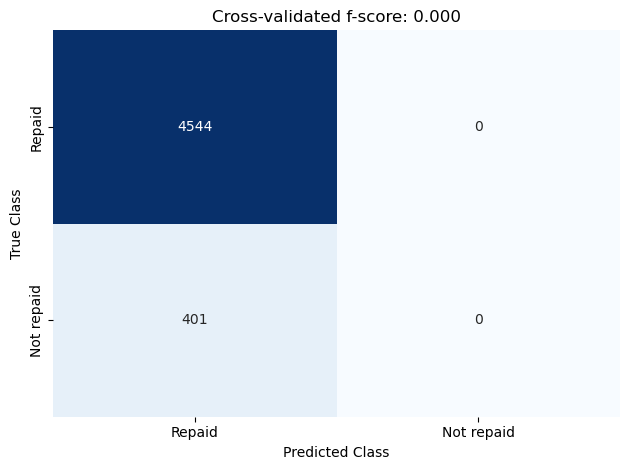

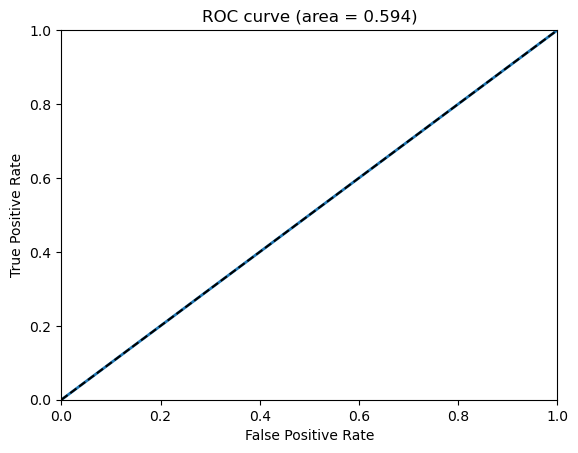

In [33]:
random_forest_f1 = get_estimator(random_forest_params, study, RandomForestClassifier)

random_forest_f1.fit(X_train_train, y_train_train)
y_pred = random_forest_f1.predict(X_train_val)

pretty_classification_report(random_forest_f1, X_train_val, y_train_val, class_names=[['Repaid', 'Not repaid']])

### Logistic regression

In [36]:
# params which are equal for all runs
logistic_regression_params = {
    'random_state': SEED,
    'n_jobs': -1,
    'penalty': 'elasticnet',
    'solver': 'saga'
}

def objective(trial):
    
        # hyperparameters
    
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    
        # model
        model = LogisticRegression(
            **logistic_regression_params,
            C=C,
            l1_ratio=l1_ratio
        )
        
        model.fit(X_train_train_downsampled, y_train_train_downsampled)
        y_pred = model.predict(X_train_val)
        score = train_scorer(model, X_train_val, y_train_val)
    
        return score

N_ITER = 200

In [37]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction='maximize', study_name='logistic_regression')

study.optimize(objective, n_trials=N_ITER, n_jobs=-1, callbacks=[OptunaProgressBar(N_ITER)])

Score: 0.5000 (best - 0.5000, trial 17): 100%|██████████| 400/400 [00:43<00:00,  9.09it/s]


### Logistic regression without custom metric

In [39]:
# params which are equal for all runs
logistic_regression_params = {
    'random_state': SEED,
    'n_jobs': -1,
    'penalty': 'elasticnet',
    'solver': 'saga'
}

def objective(trial):
    
        # hyperparameters
    
        C = trial.suggest_float('C', 1e-3, 1e3, log=True)
        l1_ratio = trial.suggest_float('l1_ratio', 0, 1)
    
        # model
        model = LogisticRegression(
            **logistic_regression_params,
            C=C,
            l1_ratio=l1_ratio
        )
        
        model.fit(X_train_train_downsampled, y_train_train_downsampled)
        y_pred = model.predict(X_train_val)
        score = f1_score(y_train_val, y_pred)
    
        return score

N_ITER = 200

In [40]:
optuna.logging.set_verbosity(0)
study = optuna.create_study(direction='maximize', study_name='logistic_regression')

study.optimize(objective, n_trials=N_ITER, n_jobs=-1, callbacks=[OptunaProgressBar(N_ITER)])

Score: 0.0000 (best - 0.0000, trial 6): 100%|██████████| 400/400 [00:43<00:00,  9.11it/s]


# Why our models are so bad?

In [41]:
status_df

,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,0,Cash loans,M,N,Y,0.0,180000.0,1256400.0,40657.5,900000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,8.0
1,1,Cash loans,F,N,Y,1.0,202500.0,436032.0,28516.5,360000.0,...,0,0,0,0,nan,nan,nan,NaN,nan,NaN
2,0,Cash loans,F,N,Y,0.0,135000.0,81000.0,9135.0,81000.0,...,0,0,0,0,nan,nan,nan,NaN,nan,NaN
3,0,Cash loans,F,N,Y,1.0,63000.0,284400.0,18513.0,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
4,0,Cash loans,M,Y,Y,1.0,202500.0,518562.0,25078.5,463500.0,...,0,0,0,0,nan,nan,nan,NaN,nan,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30900,1,Cash loans,M,N,Y,0.0,135000.0,545040.0,25407.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
30901,0,Cash loans,M,N,N,0.0,54000.0,454500.0,14661.0,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,4.0,1.0
30902,0,Cash loans,M,Y,Y,0.0,216000.0,531000.0,27243.0,531000.0,...,0,0,0,0,nan,nan,nan,NaN,nan,NaN
30903,1,Revolving loans,F,N,N,0.0,225000.0,270000.0,13500.0,270000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
